In [1]:
import sys
import datacube
import numpy as np
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

sys.path.append('../../Scripts')
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs

from dea_plotting import xr_animation
from dea_coastaltools import tidal_tag
from skimage.color import rgb2hsv, hsv2rgb

def hue_sat_val(rgb_array,
                hue_mult=1, 
                sat_mult=0.8, 
                val_mult=1):   
    
    # Convert to HSV and multiply bands
    hsv_array = rgb2hsv(rgb_array)
    hsv_array[:, :, 0] = hsv_array[:, :, 0] * hue_mult
    hsv_array[:, :, 1] = hsv_array[:, :, 1] * sat_mult
    hsv_array[:, :, 2] = hsv_array[:, :, 2] * val_mult
    
    # Convert back to RGB
    return hsv2rgb(hsv_array.clip(0, 1))


dc = datacube.Datacube(app='Animated timeseries' )

%load_ext autoreload
%autoreload 2

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


In [2]:
# Configure local dask cluster
from dea_dask import create_local_dask_cluster
create_local_dask_cluster()

# # Create dask gateway cluser
# from dea_tools.dask import create_dask_gateway_cluster
# cluster = create_dask_gateway_cluster()

Client Scheduler: tcp://127.0.0.1:39675 Dashboard: /user/robbibt/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


In [11]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geopolygon = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4) 

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [12]:
# Input params
bands=['nbart_red', 'nbart_green', 'nbart_blue', 'fmask']
# bands=['nbart_swir_1', 'nbart_nir', 'nbart_green', 'nbart_red']
time = ('2020', '2021')

# Landsat, native res
crs = mostcommon_crs(dc=dc, 
                     product='ga_ls5t_ard_3', 
                     query={'time': '1990', 
                            'geopolygon': geopolygon})

query = {
    'geopolygon': geopolygon,
    'time': time,
    'measurements': bands,
    'resampling': {'fmask': 'nearest', 
                   'oa_fmask': 'nearest', 
                   '*': 'nearest'},
    'output_crs': crs,
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'dask_chunks': {'time': 1, 'x': 3000, 'y': 3000}
}

# # Landsat upscaled res
# crs = mostcommon_crs(dc=dc, 
#                      product='ga_ls5t_ard_3', 
#                      query={'time': '1990', 
#                             'geopolygon': geopolygon})

# query = {
#     'geopolygon': geopolygon,
#     'time': time,
#     'measurements': bands,
#     'resampling': {'fmask': 'nearest', 
#                    'oa_fmask': 'nearest', 
#                    '*': 'cubic'},
#     'output_crs': crs,
#     'resolution': (-10, 10),
#     'group_by': 'solar_day',
#     'dask_chunks': {'time': 1, 'x': 3000, 'y': 3000}
# }

# # Sentinel-2 10m res
# crs = mostcommon_crs(dc=dc, 
#                      product='s2a_ard_granule', 
#                      query={'time': '2018', 
#                             'geopolygon': geopolygon})

# query = {
#     'products': 
#     'geopolygon': geopolygon,
#     'time': time,
#     'measurements': bands,
#     'resampling': {'fmask': 'nearest', 
#                    'oa_fmask': 'nearest', 
#                    '*': 'cubic'},
#     'output_crs': crs,
#     'resolution': (-20, 20),
#     'group_by': 'solar_day',
#     'dask_chunks': {'time': 1, 'x': 3000, 'y': 3000}
# }

In [13]:
# Load data
ds = load_ard(
    dc=dc,
    products=[
        "ga_ls5t_ard_3",
        "ga_ls7e_ard_3",
        "ga_ls8c_ard_3",
#         "s2a_ard_granule",
#         "s2b_ard_granule",
#         "s2a_nrt_granule",
#         "s2b_nrt_granule",
    ],
    min_gooddata=0.00,
    ls7_slc_off=False,
    mask_pixel_quality=False,
    **query
)

# # Optionally apply tide filtering
# ds_ls = tidal_tag(ds_ls)
# ds_ls = ds_ls.sel(time = ds_ls.tide_height < ds_ls.tide_height.median())

# Load using dask
ds = ds.compute()
ds

Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
Returning 31 time steps as a dask array


<xarray.Dataset>
Dimensions:      (time: 31, x: 460, y: 368)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-09T23:44:18.656202 ... 2021-06...
  * y            (y) float64 -3.763e+06 -3.764e+06 ... -3.774e+06 -3.774e+06
  * x            (x) float64 3.317e+05 3.317e+05 ... 3.454e+05 3.455e+05
    spatial_ref  int32 32656
Data variables:
    nbart_red    (time, y, x) int16 1857 1727 1554 1394 1292 ... 119 118 106 108
    nbart_green  (time, y, x) int16 2061 1970 1812 1676 1599 ... 167 173 164 179
    nbart_blue   (time, y, x) int16 2009 1934 1772 1655 1558 ... 295 292 284 289
    fmask        (time, y, x) uint8 2 2 2 2 2 2 2 5 5 5 ... 5 5 5 5 5 5 5 5 5 5
Attributes:
    crs:           epsg:32656
    grid_mapping:  spatial_ref

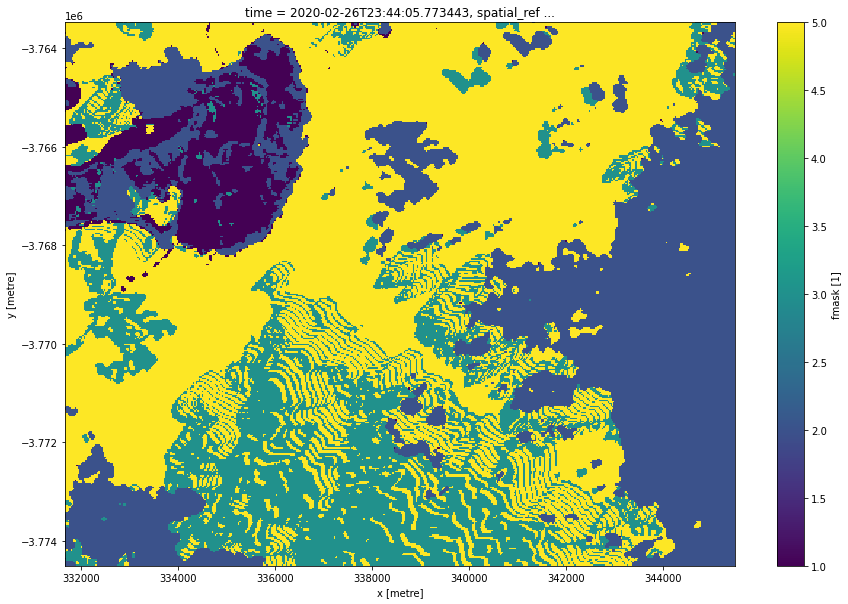

In [30]:
ds.fmask.isel(time=3).plot(size=10)

In [27]:
ds.fmask.flags_definition

{'fmask': {'bits': [0, 1, 2, 3, 4, 5, 6, 7],
  'values': {'0': 'nodata',
   '1': 'valid',
   '2': 'cloud',
   '3': 'shadow',
   '4': 'snow',
   '5': 'water'},
  'description': 'Fmask'}}

### Apply rolling median to smooth out noise and focus on change
Also calculates median surface reflectance over entire time series as an input to `match_histograms` which will reduce scene-to-scene variability

In [6]:
# Apply rolling median (or optionally, annual resampling)
ds_rolling = ds.rolling(time=40, center=True, min_periods=1).median()
# ds_rolling = ds.resample(time='Y').median(dim='time').rolling(time=3, center=True, min_periods=1).median()

# Calculate all of time median
median_array = np.transpose(ds_rolling[bands]
                            .median(dim='time')
                            .to_array().values, 
                            axes=(1, 2, 0))
print(ds_rolling)

<xarray.Dataset>
Dimensions:      (time: 613, x: 46, y: 41)
Coordinates:
  * time         (time) datetime64[ns] 1987-05-22T23:08:32.101946 ... 2021-06...
  * y            (y) float64 -3.911e+06 -3.911e+06 ... -3.912e+06 -3.912e+06
  * x            (x) float64 2.707e+05 2.707e+05 ... 2.72e+05 2.721e+05
    spatial_ref  int32 32656
Data variables:
    nbart_red    (time, y, x) float32 180.0 166.0 170.5 ... 114.0 98.0 99.0
    nbart_green  (time, y, x) float32 376.0 311.5 312.0 ... 211.0 202.0 207.0
    nbart_blue   (time, y, x) float32 345.0 312.0 303.5 ... 314.0 305.0 302.0


## Run animation
`funcs_list` provides a series of image processing functions that are applied to each satellite frame. 
The default values are only examples - each animation will probably require fine tuning (or may not require all techniques at all).

Exporting animation to animation_bowling.mp4


  0%|          | 0/613 (0.0 seconds remaining at ? frames/s)

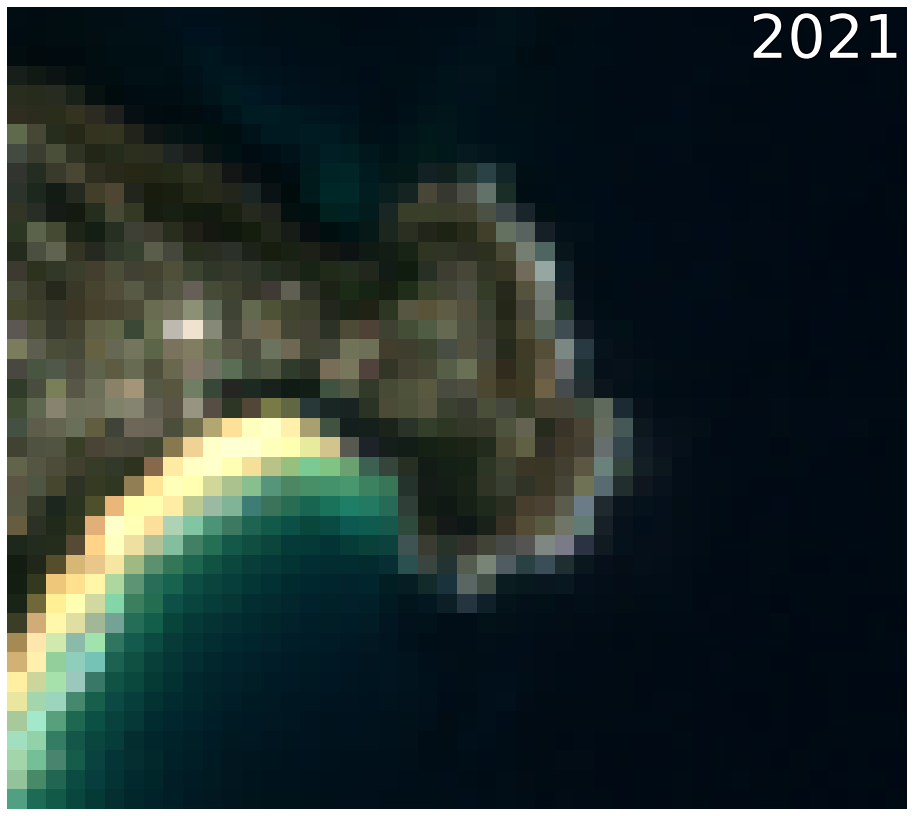

In [7]:
import numpy as np
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity, adjust_sigmoid

funcs_list = [
              # Apply `match_histograms` to reduce scene-to-scene variability
              lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
    
              # Apply power transform to reduce bright highlights  
              lambda x: x**0.8,
    
              # Rescale values to range accepted by `xr_animation`
              rescale_intensity,
    
              # Apply different levels of unsharp masking to enhance
              # overall dynamic range, and improve fine scale detail
              lambda x: unsharp_mask(x, radius=20, amount=0.2),
              lambda x: unsharp_mask(x, radius=5, amount=0.1),
              
              # # Contrast enhancement using sigmoid transform
              # lambda x: adjust_sigmoid(image=x, cutoff=0.7, gain=3)
             ]
# funcs_list = None

xr_animation(output_path='animation_timeseries.mp4',
             ds=ds_rolling,
             show_text='',
             bands=bands[0:3],
             interval=50,
             width_pixels=900,
             percentile_stretch=(0.01, 0.99),
             image_proc_funcs=funcs_list,
             show_date='%Y',
             annotation_kwargs={'fontsize': 60},
            ) 

## Specialised animations

### DEA CoastLines animations

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib

# Get bounding box of data
xmin, ymin, xmax, ymax = ds_ls.geobox.geographic_extent.boundingbox

# Set up WFS requests for annual coastlines & rates of change statistics
deacl_coastlines_wfs = 'https://geoserver.dea.ga.gov.au/geoserver/wfs?' \
                       'service=WFS&version=1.1.0&request=GetFeature&' \
                       'typeName=dea:coastlines&maxFeatures=1000&' \
                      f'bbox={ymin},{xmin},{ymax},{xmax},urn:ogc:def:crs:EPSG:4326'

# Load data from WFS and set CRS
deacl_gdf = gpd.read_file(deacl_coastlines_wfs)
deacl_gdf.crs = 'EPSG:3577'

# Clip to extent of satellite data
bbox = gpd.GeoDataFrame(geometry=[ds_ls.geobox.extent.geom],
                        crs=ds_ls.geobox.crs)  
deacl_gdf = gpd.overlay(deacl_gdf, bbox.to_crs(deacl_gdf.crs))
deacl_gdf = deacl_gdf.dissolve('year')

# Apply colours
norm = matplotlib.colors.Normalize(vmin=0, vmax=len(deacl_gdf.index))
cmap = matplotlib.cm.get_cmap('inferno')
rgba = cmap(norm(deacl_gdf.reset_index().index))
deacl_gdf['color'] = list(rgba)
deacl_gdf['start_time'] = (pd.to_datetime(deacl_gdf.index) + 
                           pd.DateOffset(months=5))

# Remove a year
# deacl_gdf = deacl_gdf.drop('1993')

deacl_gdf.plot()

In [ ]:
# minx, miny, maxx, maxy = deacl_gdf.unary_union.bounds
# from shapely.geometry import box
# import geopandas as gpd
# test = box(minx, -3570200, maxx, maxy)
# deacl_gdf = gpd.clip(deacl_gdf, gpd.GeoSeries(test, crs='EPSG:3577')) 
# deacl_gdf.plot()

In [ ]:
import numpy as np
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity, adjust_sigmoid

funcs_list = [lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
#               lambda x: x**0.5,
              rescale_intensity,
#               hue_sat_val,
              lambda x: unsharp_mask(x, radius=20, amount=0.3),
              lambda x: unsharp_mask(x, radius=5, amount=0.2),
#               lambda x: adjust_sigmoid(image=x, cutoff=0.7, gain=3)
             ]
# funcs_list = None

xr_animation(output_path='deacoastlines_annual_pelicanpoint.mp4',
             ds=ds_rolling,  #.isel(time=slice(10, -1)),
             show_text='',
             bands=bands,
             interval=80,
             width_pixels=900,
             percentile_stretch=(0.01, 0.99),
             image_proc_funcs=funcs_list,
             show_date='%Y',
             annotation_kwargs={'fontsize': 55},
             show_gdf=deacl_gdf,
             gdf_kwargs = {'linewidth': 2.5},
             imshow_kwargs={'vmin': -0.5, 'vmax': 0.7},   # Stuart Point, Twilight Bay
#              imshow_kwargs={'vmin': -0.2, 'vmax': 0.6},
#              limit=30,
            ) 

In [ ]:
import numpy as np
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity, adjust_sigmoid

funcs_list = [
              lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
              lambda x: x**0.8,
              rescale_intensity,
#               hue_sat_val,
              lambda x: unsharp_mask(x, radius=20, amount=0.2),
              lambda x: unsharp_mask(x, radius=5, amount=0.1),
#               lambda x: adjust_sigmoid(image=x, cutoff=0.7, gain=3)
             ]
# funcs_list = None

xr_animation(output_path='animation_sydney.mp4',
             ds=ds_rolling,  #.isel(time=slice(1, -1)),
             show_text='',
             bands=bands,
             interval=50,
             width_pixels=900,
             percentile_stretch=(0.01, 0.99),
             image_proc_funcs=funcs_list,
             show_date='%Y',
             annotation_kwargs={'fontsize': 60},
             show_gdf=deacl_gdf,
             gdf_kwargs = {'linewidth': 2.5},
#              imshow_kwargs={'vmin': -0.5, 'vmax': 0.7},   # Stuart Point, Twilight Bay
#              imshow_kwargs={'vmin': -0.2, 'vmax': 0.6},
#              limit=10,
            ) 

In [ ]:
site='spoilbank'
!ffmpeg -y -i deacoastlines_annual_{site}.mp4 -i deacoastlines_inset_{site}.png \
-filter_complex "[0:v][1:v] overlay=0:0:enable='between(t,0,20)'" \
-pix_fmt yuv420p -c:a copy \
deacoastlines_annualwithinset_{site}.mp4

In [ ]:
!ffmpeg -y -i 'Landsat 5 7 8 - 1987-2019 - Corner Inlet - True colour animation.mp4' -i seminar_title.png \
-filter_complex "[0:v][1:v] overlay=0:0:enable='between(t,0,20)'" \
-pix_fmt yuv420p -c:a copy \
seminar_with_title.mp4

### Animated fade

In [ ]:
import imageio
import numpy as np

from_array = imageio.imread('tides_fade/tides_low.png')
to_array = imageio.imread('tides_fade/tides_high.png')

framerate = 30
pause = 3500
frames = 20

stacked_from_to = np.stack([to_array, from_array], axis=3)

intervals = np.linspace(0, 1.0, frames + 1).tolist()
weights = intervals + intervals[::-1][1:-1]
milliseconds = [pause] + [framerate] * (len(intervals) - 2) + [pause] + [framerate] * (len(intervals) - 2)
# weights = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
# milliseconds = [50, 50, 50, 50, 50, 50, 50, 50, 50, 3500, 50, 50, 50, 50, 50, 50, 50, 50, 50, 3500]

for i, weight in enumerate(weights):

    ave_from_to = np.average(stacked_from_to, axis=3, weights=np.array([weight, 1.0 - weight]))
    imageio.imwrite(f'tides_fade/output_{i}_({milliseconds[i]}ms).png', ave_from_to.astype(np.uint8))


### Mangrove animation

In [ ]:
import numpy as np
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity, adjust_sigmoid

ndvi = (d
        
        
        
        s_rolling["nbart_nir"] - ds_rolling["nbart_red"])/(ds_rolling["nbart_nir"] + ds_rolling["nbart_red"])
ds_rolling2 = ds_rolling * rescale_intensity(image=ndvi, in_range=(0, 0.8), out_range=(0, 1.0))



In [ ]:

funcs_list = [
#               lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
#               lambda x: x**0.8,
#               ndvi_mult,
              rescale_intensity,
#               hue_sat_val,
#               lambda x: unsharp_mask(x, radius=20, amount=0.2),
#               lambda x: unsharp_mask(x, radius=5, amount=0.1),
#               lambda x: adjust_sigmoid(image=x, cutoff=0.7, gain=3)
             ]
funcs_list = None

xr_animation(output_path='animation_bowling.mp4',
             ds=ds_rolling2.isel(time=slice(20, -10)),
             show_text='',
             bands=bands[0:3],
             interval=50,
             width_pixels=900,
             percentile_stretch=(0.001, 0.999),
             image_proc_funcs=funcs_list,
             show_date='%Y',
             annotation_kwargs={'fontsize': 60},
#              show_gdf=deacl_gdf,
#              gdf_kwargs = {'linewidth': 2.5},
#              imshow_kwargs={'vmin': -0.5, 'vmax': 0.7},   # Stuart Point, Twilight Bay
#              imshow_kwargs={'vmin': -0.2, 'vmax': 0.6},
#              limit=20,
            ) 